In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
import cv2

%matplotlib inline

## Tools

In [14]:
def compare_plot_images(original, modified, output_path=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,12))
    f.tight_layout()
    
    ax1.set_title("Original Image", fontsize=15)
    ax2.set_title("Modified Image", fontsize=15)
    
    ax1.imshow(original, cmap='gray')
    ax2.imshow(modified, cmap='gray')
    
    if(output_path):
        plt.savefig(output_path, dpi=100)

In [15]:
image = glob.glob("3.jpg")
image = mpimg.imread(image[0])

## Sobel and HLS Techniques Combined

In [16]:
def binary_image(image, sobel_kernel=3, thresh=(0,255)):
    # HLS
    # convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # take both sobel x and y gradients
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # calculate the gradient magnitude
    gradmag = np.sqrt(sobel_x**2 +sobel_y**2)
    
    # rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    # threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > 90) & (s_channel <= 255)] = 1
    
    combined_binary = np.zeros_like(mag_binary)
    combined_binary[(s_binary ==1) | (mag_binary ==1)] = 1
    
    return combined_binary

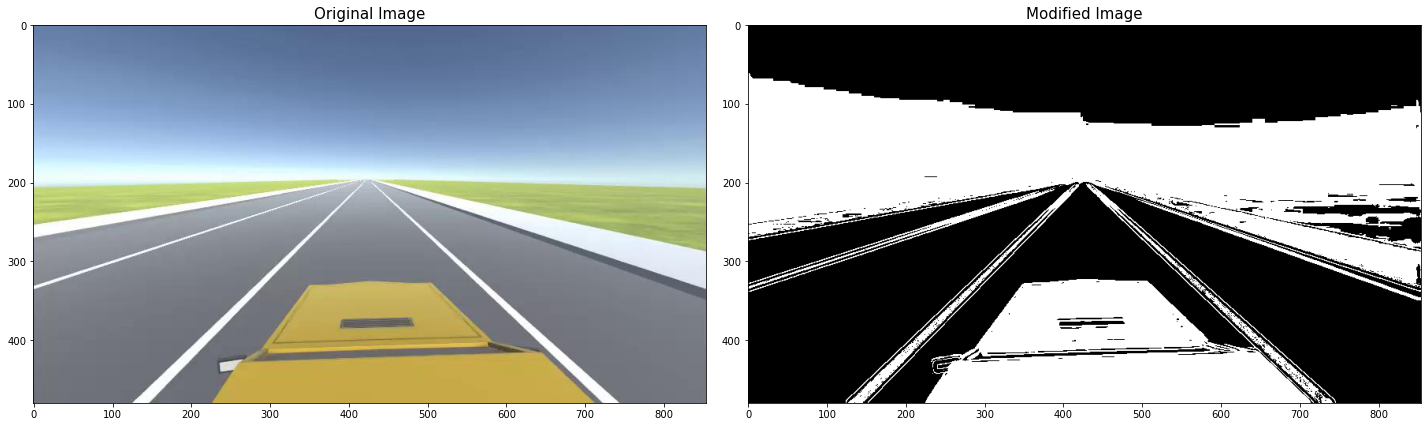

In [17]:
ksize = 15
binary_output = binary_image(image, sobel_kernel=ksize, thresh=(30, 100))

compare_plot_images(image, binary_output)

## Perspective Transform

In [18]:
# poly_src = np.float32(
#                 [[400, 210],
#                  [450, 210],
#                  [600, 350],
#                  [250, 350]])
# poly_dest = np.float32(
#                  [[50, 25],
#                   [800, 25],
#                   [800, 350],
#                   [50, 350]])

poly_src = np.float32(
                [[400, 210],
                 [450, 210],
                 [600, 280],
                 [250, 280]])
poly_dest = np.float32(
                 [[50, 25],
                  [800, 25],
                  [800, 450],
                  [50, 450]])

def warp_image(image):
    img_size = (image.shape[1], image.shape[0])
    
    
    M = cv2.getPerspectiveTransform(poly_src, poly_dest)
    
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

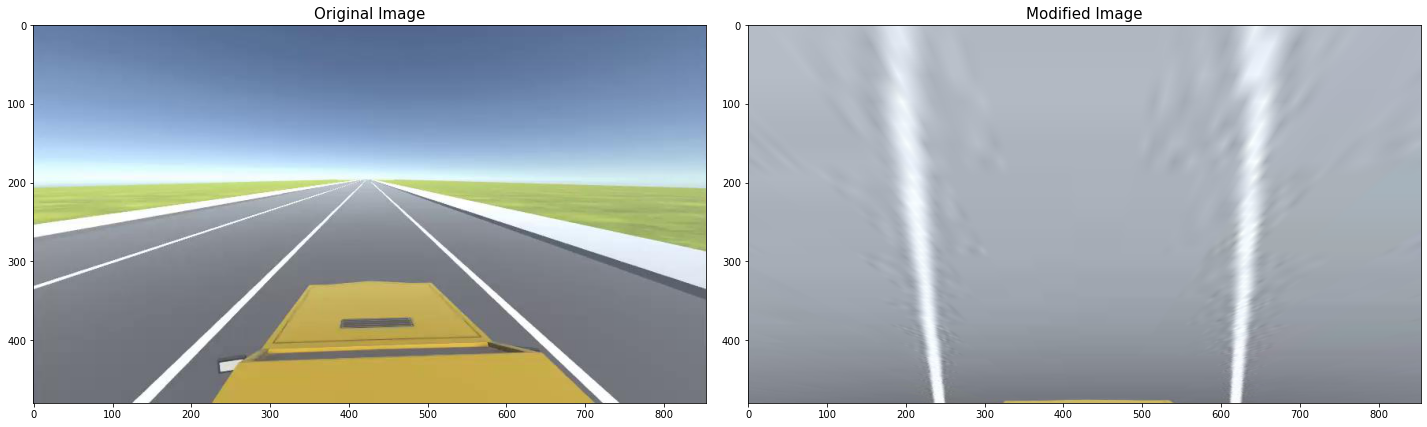

In [19]:
image = glob.glob("3.jpg")
image = mpimg.imread(image[0])
# image = crop_image_remove_car(image)

binary_warped_img = warp_image(image)

compare_plot_images(image, binary_warped_img)

## Detect Lane Pixels and Find the Lane Boundary

In [20]:
def find_lane_pixels(binary_img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_img[binary_img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_img, binary_img, binary_img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_img.shape[0] - (window+1)*window_height
        win_y_high = binary_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [21]:
def fit_polynomial(binary_img):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_img)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return ploty, left_fitx, right_fitx, out_img

<ipython-input-20-46f61823f913>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]//2)
<ipython-input-20-46f61823f913>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20

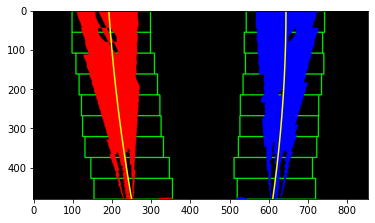

In [24]:
combined = binary_image(image, sobel_kernel=ksize, thresh=(30, 100))
binary_warped_combined_img = warp_image(combined)

ploty, left_fitx, right_fitx, out_img = fit_polynomial(binary_warped_combined_img)

plt.imshow(out_img)
plt.savefig("../output_images/fit_poly.jpg", dpi=100)

## Determine the Curvature of the Lane and Vehicle Position with respect to Center

In [25]:
def measure_curvature_real(binary_warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [26]:
def center_offset(binary_warped):
    car_center = binary_warped.shape[1]//2
    
    y = binary_warped.shape[0]//2

    xm_per_pix = 3.7/700
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
        
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    left = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    
    lane_center = (right - left)/2 + left
    
    offset = lane_center - car_center
    offset = (np.abs(car_center) - np.abs(lane_center)) * xm_per_pix
    
    return offset

In [27]:
left_curverad, right_curverad = measure_curvature_real(binary_warped_combined_img)
print(left_curverad, right_curverad)

1513.8264863277616 1128.6259196070378


<ipython-input-20-46f61823f913>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]//2)
<ipython-input-20-46f61823f913>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20

## Unwarp Image Back to its Original Position

In [28]:
def unwarp_image(img):
    img_size = (img.shape[1], img.shape[0])

    M = cv2.getPerspectiveTransform(poly_dest, poly_src)
    
    unwarped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return unwarped

In [29]:
def draw_detection(ploty, left_fitx, right_fitx, out_img, binary_warped):
    zero = np.zeros_like(binary_warped).astype(np.uint8)
    output = np.dstack((zero, zero, zero))

    left = np.array([np.column_stack([left_fitx, ploty])])
    right = np.array([np.flipud(np.column_stack([right_fitx, ploty]))])
    all_pts = np.hstack((left, right))

    cv2.fillPoly(output, np.int_([all_pts]), (0,255, 0))

    return output

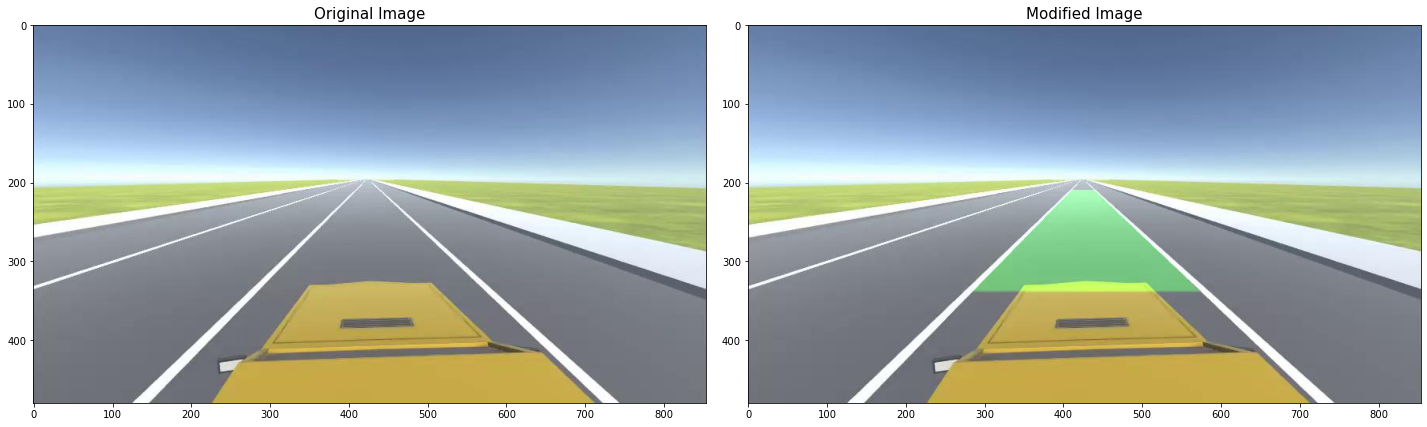

In [30]:
draw_output = draw_detection(ploty, left_fitx, right_fitx, out_img, binary_warped_combined_img)

unwarped = unwarp_image(draw_output)

result = cv2.addWeighted(image, 1, unwarped, 0.3, 0)

compare_plot_images(image, result)

## Lane Detection Pipeline

<ipython-input-20-46f61823f913>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]//2)
<ipython-input-20-46f61823f913>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20

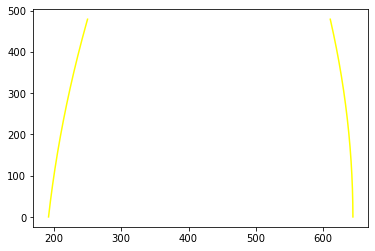

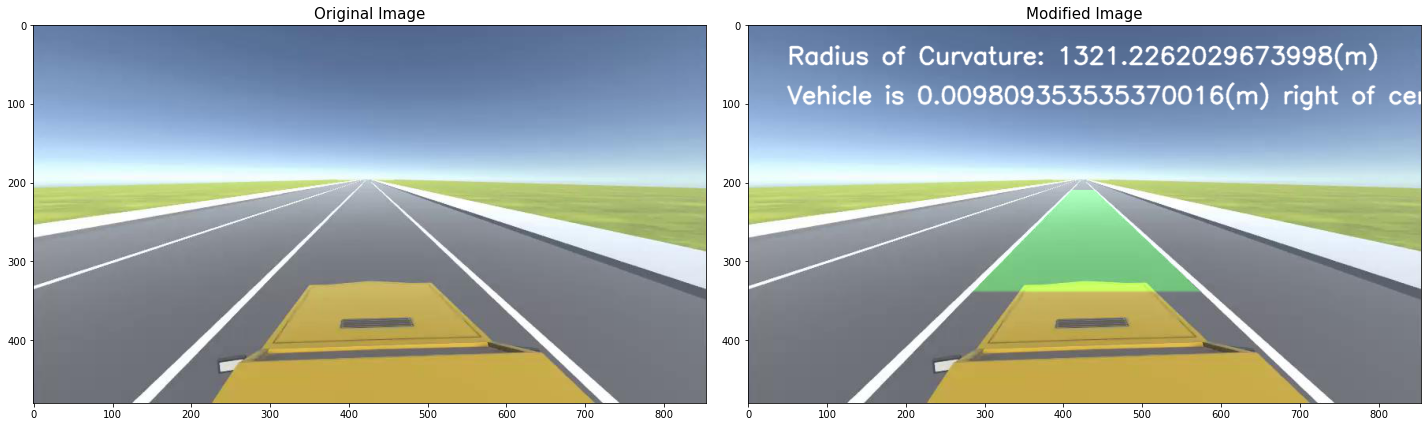

In [31]:
def pipeline(image):
    ksize = 15
    binary_output = binary_image(image, sobel_kernel=ksize, thresh=(30, 100))

    binary_warped = warp_image(binary_output)
    
    ploty, left_fitx, right_fitx, out_img = fit_polynomial(binary_warped)
    
    draw_output = draw_detection(ploty, left_fitx, right_fitx, out_img, binary_warped)
    
    unwarped = unwarp_image(draw_output)
    
    left_curverad, right_curverad = measure_curvature_real(binary_warped)
    
    offset = center_offset(binary_warped)

    result = cv2.addWeighted(image, 1, unwarped, 0.3, 0)

    result = cv2.putText(result, 'Radius of Curvature: ' + str((left_curverad+right_curverad)/2) + '(m)', (50, 50), cv2.FONT_HERSHEY_SIMPLEX , 1, (255, 255, 255), 2, cv2.LINE_AA) 
    
    if(offset < 0):
        result = cv2.putText(result, 'Vehicle is ' + str(abs(offset)) + '(m) left of center', (50, 100), cv2.FONT_HERSHEY_SIMPLEX , 1, (255, 255, 255), 2, cv2.LINE_AA) 
    else:
        result = cv2.putText(result, 'Vehicle is ' + str(abs(offset)) + '(m) right of center', (50, 100), cv2.FONT_HERSHEY_SIMPLEX , 1, (255, 255, 255), 2, cv2.LINE_AA) 
    
    return result

image = glob.glob("3.jpg")
image = mpimg.imread(image[0])
# image = crop_image_remove_car(image)

result = pipeline(image)   

compare_plot_images(image, result)

## Process Video

In [32]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip("straight_right_twocars.mp4", 0, 5, targetname="straight_right_twocars_new.mp4")

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


t:   1%|▏         | 2/151 [00:00<00:09, 16.06it/s, now=None]

Moviepy - Building video ./lane_detection_demo.mp4.
Moviepy - Writing video ./lane_detection_demo.mp4



Moviepy - Done !
Moviepy - video ready ./lane_detection_demo.mp4
CPU times: user 17.6 s, sys: 608 ms, total: 18.2 s
Wall time: 16.9 s


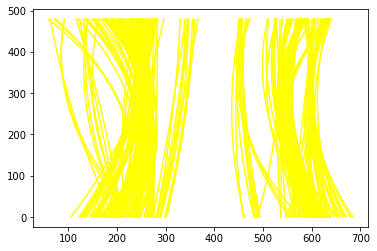

In [34]:
vid_output = "./lane_detection_demo.mp4"

clip = VideoFileClip('./straight_right_twocars_new.mp4')
white_clip = clip.fl_image(pipeline)
%time white_clip.write_videofile(vid_output, audio=False)